# SkimLiterature NLP Model
It is a label classification problem. Model will take abstract of the paper as input and output
the abstract divided into subheadings making it easier to read.

    

In [2]:
# import useful libraries
import tensorflow as tf
import numpy as np

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {tf.keras.__version__}")

# set global random seed 
np.random.seed(42)
tf.random.set_seed(42)

2024-08-03 10:55:24.983586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 10:55:24.983714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 10:55:25.127097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version: 2.15.0
keras version: 3.4.1


## Explore the Training data from PubMed 20k
> A small data set consisting of 20,000 samples will be explored first.

> This will be useful for fast training of deep neural networks.


In [3]:
train_text_filepath_20k = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
val_text_filepath_20k = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"
test_text_filepath_20k = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"

In [4]:
def read_text_files(filepath_list):
    """
    Function to read lines of a text file.
    
    Args:
        filepath_list (list of str): list of all file paths
        
    Returns:
        file_data_list (list of str): list containing all the lines in the input file path list
    """
    
    file_data_list = []
    for file in filepath_list:
        with open(file) as f:
            file_data_list.append(f.readlines())
            
    return file_data_list

In [5]:
# read train, dev and test files
file_data_list_20k = read_text_files([train_text_filepath_20k,
                                      val_text_filepath_20k,
                                      test_text_filepath_20k])

train_text_20k = file_data_list_20k[0]
val_text_20k = file_data_list_20k[1]
test_text_20k = file_data_list_20k[2]

In [6]:
train_text_20k[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
train_text_20k[1][-20:].split()

['oarthritis', '(', 'OA', ')', '.']

In [8]:
def preprocess_text_data(text):
    """
    Preprocesses the input text data and returns it in the form of a 
    dictionary. The output dictionary will consist of each sentence, 
    its target (label) line number of each sentence and total number of lines.
    
    Args:
        text (list of str): it will be in a specific format
        
    Returns:
        output_dict (dict): formatted text in the form of a dictionary
    """
    
    line_number = []
    total_lines = []
    sentences = []
    sentence_target = []
    
    line_count = 0
    for line in text:
        
        if line.startswith("###"):
            pass
            
        elif line.isspace():
            for i in range(line_count):
                total_lines.append(line_count)
            line_count = 0
            
        else:
            line_number.append(line_count)
            
            line_split = line.split("\t")
            sentence_target.append(line_split[0])
            sentences.append(line_split[1])
            
            line_count += 1
    
    output_dict = {"target": sentence_target,
                   "sentence": sentences,
                   "line_number": line_number,
                   "total_lines": total_lines}
    
    return output_dict
        

In [9]:
# get train, dev and test data in the form of dictionary
train_dict_20k = preprocess_text_data(train_text_20k)
val_dict_20k = preprocess_text_data(val_text_20k)
test_dict_20k = preprocess_text_data(test_text_20k)

In [10]:
# convert dictionaries to pandas dataframe
import pandas as pd

train_df_20k = pd.DataFrame(train_dict_20k)
val_df_20k = pd.DataFrame(val_dict_20k)
test_df_20k = pd.DataFrame(test_dict_20k)

train_df_20k.head(5)

,target,sentence,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12


In [11]:
# get the output target labels
output_classes = train_df_20k["target"].unique().tolist()
num_classes = len(output_classes)
output_classes

['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND']

In [12]:
# one hot encode the train, val and test labels
# note that one hot encoder is fit_transform on train labels
# for val and test labels only transform method is called
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_20k_one_hot = one_hot_encoder.fit_transform(train_df_20k["target"].to_numpy().reshape(-1, 1))
val_labels_20k_one_hot = one_hot_encoder.transform(val_df_20k["target"].to_numpy().reshape(-1, 1))
test_labels_20k_one_hot = one_hot_encoder.transform(test_df_20k["target"].to_numpy().reshape(-1, 1))

In [13]:
# get list of sentences and their labels for train, val (dev) and test data
train_sentences_20k = train_df_20k["sentence"].tolist()
train_labels_20k = train_df_20k["target"].tolist()

val_sentences_20k = val_df_20k["sentence"].tolist()
val_labels_20k = val_df_20k["target"].tolist()

test_sentences_20k = test_df_20k["sentence"].tolist()
test_labels_20k = test_df_20k["target"].tolist()

train_sentences_20k[:5], train_labels_20k[:5]

(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n'],
 ['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS'])

# Tokenization of Text Data
Neural networks need data in numerical form.

* Word Level Tokenization
* Character Level Tokenization



## Word Level Tokenization

total words (train): 4741942
average sentence length (train): 26.338269273494777
97% of sentences (train) have length of around: 62


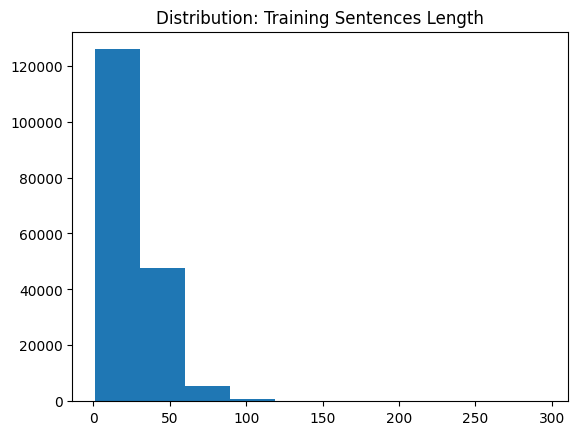

In [14]:
# check some parameters of training data
# plot the distribution of training sentence length
import numpy as np
import matplotlib.pyplot as plt

train_sentence_length_20k = ([len(sentence.split()) for sentence in train_sentences_20k])

total_words_train_20k = sum(train_sentence_length_20k)
mean_sentence_len_20k = np.mean(train_sentence_length_20k)

sentence_length_percentile_20k = 97
sequence_length_20k = int(np.percentile(train_sentence_length_20k, 
                                        sentence_length_percentile_20k))

print(f"total words (train): {total_words_train_20k}")
print(f"average sentence length (train): {mean_sentence_len_20k}")
print(f"{sentence_length_percentile_20k}% of sentences (train) have length of around: {sequence_length_20k}")

plt.hist(train_sentence_length_20k)
plt.title("Distribution: Training Sentences Length");

In [15]:
# create a vectroizer for tokenization of sentences (word level tokenization)
import tensorflow as tf

sen_vectorizer_20k = tf.keras.layers.TextVectorization(output_sequence_length=sequence_length_20k)
sen_vectorizer_20k.adapt(train_sentences_20k)

sen_vocabulary_size_20k = len(sen_vectorizer_20k.get_vocabulary())

print(f"Vocabulary Size: {sen_vocabulary_size_20k}")

Vocabulary Size: 64841


In [16]:
# check tokenization of a random sentence
import random

example_sentence = random.choice(train_sentences_20k)
print(f"Example Sentence: \n{example_sentence}")
print(f"Tokenized Sentence: \n{sen_vectorizer_20k(example_sentence)}")

Example Sentence: 
The study compared injection of MSCs ( n = @ ) with placebo ( n = @ ) and BMCs ( n = @ ) with placebo ( n = @ ) , with @ year of follow-up .

Tokenized Sentence: 
[    2    17    34   390     4  6628    40     7    48    40     3 16228
    40     7    48    40     7   157     4    94     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [17]:
# tokenize the train, val (dev) and test data using tf.keras.layers.TextVectorization
train_sen_tokenized_20k = sen_vectorizer_20k(train_sentences_20k)
val_sen_tokenized_20k = sen_vectorizer_20k(val_sentences_20k)
test_sen_tokenized_20k = sen_vectorizer_20k(test_sentences_20k)

train_sen_tokenized_20k[0]

<tf.Tensor: shape=(62,), dtype=int64, numpy=
array([   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
          5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
       1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
        350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

## Character Level Tokenization

In [18]:
example = " ".join(train_sentences_20k[0])
example

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n'

In [19]:
def char_level_split(list_of_sentences):
    """
    Formats (character level) the input list of sentences and returns
    the formatted data.
    
    Args:
        list_of_sentences (list of str): input list of sentences to format
        
    Returns:
        char_sentences (list of str): character formatted output data
    """
    char_sentences = []
    for sentence in list_of_sentences:
        char_sentences.append(" ".join(sentence))
        
    return char_sentences

In [20]:
# format (character level) the train, val and test data 
train_char_20k = char_level_split(train_sentences_20k)
val_char_20k = char_level_split(val_sentences_20k)
test_char_20k = char_level_split(test_sentences_20k)

train_char_20k[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   . \n'

In [21]:
import string

total_characters = string.ascii_lowercase + string.punctuation + string.digits
print(f"Characters: {total_characters}")
print(f"Total Characters: {len(total_characters)}")

Characters: abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789
Total Characters: 68


total chars (train): 22329999
average characters in a sentence (train): 124.02798822483892
95% of sentences (train) have length of around: 239


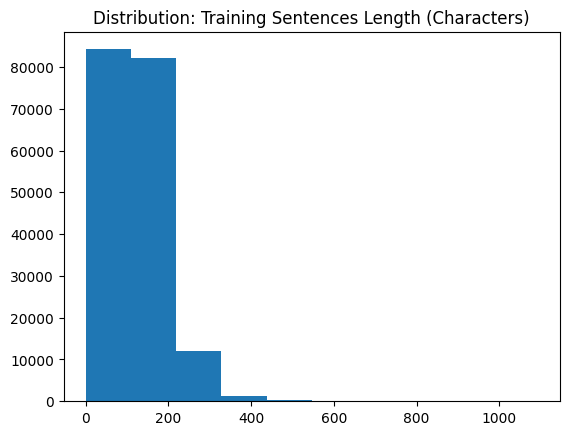

In [22]:
# check the distribution of sentence length (character level)

import numpy as np
import matplotlib.pyplot as plt

train_char_length_20k = ([len(sentence.split()) for sentence in train_char_20k])

total_chars_train_20k = sum(train_char_length_20k)
mean_char_sentence_len_20k = np.mean(train_char_length_20k)

char_percentile_20k = 95
char_sequence_length_20k = int(np.percentile(train_char_length_20k, 
                                             char_percentile_20k))

print(f"total chars (train): {total_chars_train_20k}")
print(f"average characters in a sentence (train): {mean_char_sentence_len_20k}")
print(f"{char_percentile_20k}% of sentences (train) have length of around: {char_sequence_length_20k}")

plt.hist(train_char_length_20k)
plt.title("Distribution: Training Sentences Length (Characters)");

In [23]:
# create a vectorizer for character level tokenization of train, val and test data
import tensorflow as tf

char_vectorizer_20k = tf.keras.layers.TextVectorization(output_sequence_length=char_sequence_length_20k)
char_vectorizer_20k.adapt(train_char_20k) # adapt on training data only

char_vocabulary_size_20k = len(char_vectorizer_20k.get_vocabulary())
char_vocabulary_20k = char_vectorizer_20k.get_vocabulary()

print(f"Vocabulary Size: {char_vocabulary_size_20k}\n")
print(f"Vocabulary: {char_vocabulary_20k}\n")


Vocabulary Size: 28

Vocabulary: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']



In [24]:
# check the vectorizer for tokenization of a random sentence (character level formatting)
import random

example_sentence = random.choice(train_char_20k)
print(f"Example Sentence: \n{example_sentence}")
print(f"Char Tokenized Sentence: \n{char_vectorizer_20k(example_sentence)}")

Example Sentence: 
P r i m a r y   a n d   s e c o n d a r y   o u t c o m e s   w e r e   m o r t a l i t y   a n d   r e q u i r e m e n t   f o r   m a i n t e n a n c e   d i a l y s i s   ,   r e s p e c t i v e l y   ,   a s s e s s e d   i n   @ , @   (   @   %   )   p a t i e n t s   a t   a   m e d i a n   o f   @   m o n t h s   (   i n t e r q u a r t i l e   r a n g e   - L S B -   I Q R   - R S B -   @ - @   @   m o n t h s   )   p o s t   r a n d o m i z a t i o n   . 

Char Tokenized Sentence: 
[14  8  4 15  5  8 19  5  6 10  9  2 11  7  6 10  5  8 19  7 16  3 11  7
 15  2  9 20  2  8  2 15  7  8  3  5 12  4  3 19  5  6 10  8  2 26 16  4
  8  2 15  2  6  3 17  7  8 15  5  4  6  3  2  6  5  6 11  2 10  4  5 12
 19  9  4  9  8  2  9 14  2 11  3  4 21  2 12 19  5  9  9  2  9  9  2 10
  4  6 14  5  3  4  2  6  3  9  5  3  5 15  2 10  4  5  6  7 17 15  7  6
  3 13  9  4  6  3  2  8 26 16  5  8  3  4 12  2  8  5  6 18  2 12  9 22
  4 26  8  8  9 22 15  7  6  3 13  9 14  7  9  

## Efficient Data Pipeline

* Creation of Datasets using tf.data.Dataset
* Batching and Prefetching for efficient data pipeline

In [25]:
# create datasets and batch the data
# use prefetch at the end 
import tensorflow as tf

train_dataset_20k = tf.data.Dataset.from_tensor_slices((train_sentences_20k, train_labels_20k_one_hot))
val_dataset_20k = tf.data.Dataset.from_tensor_slices((val_sentences_20k, val_labels_20k_one_hot))
test_dataset_20k = tf.data.Dataset.from_tensor_slices((test_sentences_20k, test_labels_20k_one_hot))

print(len(train_dataset_20k), len(val_dataset_20k), len(test_dataset_20k))

BATCH_SIZE = 32

train_dataset_20k = train_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_20k = val_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_20k = test_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_dataset_20k)

180040 30212 30135
<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


## Build Conv1D Model (for text classification)

In [26]:
# create a helper function for plotting history of model
import matplotlib.pyplot as plt
import seaborn as sns
def plot_model_history(history):
    """
        Plots the loss and accuracy of given model history.
        
        Args:
        history (object): contains training/test loss and accuracy
    """
    
    sns.lineplot(x=history.epoch, y=history.history["loss"], label="Training Loss")
    sns.lineplot(x=history.epoch, y=history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curves")
    plt.legend()
    
    plt.figure()
    sns.lineplot(x=history.epoch, y=history.history["accuracy"], label="Training Accuracy")
    sns.lineplot(x=history.epoch, y=history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy Curves")
    plt.legend();

In [27]:
# use mixed precision policy
# tf.float16 will be used for computations and tf.float32 for saving of variables
# this will speed up the process of training 

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# build and compile the model
EMBEDDING_SIZE = 128

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
x = sen_vectorizer_20k(inputs)
x = tf.keras.layers.Embedding(input_dim=sen_vocabulary_size_20k,
                              output_dim=EMBEDDING_SIZE)(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           padding="same")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(num_classes, 
                                activation="softmax", 
                                dtype=tf.float32, 
                                name="output_layer")(x)

model_conv1d = tf.keras.Model(inputs=inputs,
                              outputs=outputs,
                              name="model_conv1d")

model_conv1d.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

model_conv1d.summary()

Model: "model_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 62)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 62, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 62, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,349,637 (31.85 MB)

 Trainable params: 8,349,637 (31.85 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# fit the model
history_model_conv1d = model_conv1d.fit(train_dataset_20k,
                                        epochs=5,
                                        steps_per_epoch=int(0.1*(len(train_dataset_20k))),
                                        validation_data=val_dataset_20k,
                                        validation_steps=int(0.1*(len(val_dataset_20k))),
                                        verbose=1)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5724 - loss: 1.0481 - val_accuracy: 0.7839 - val_loss: 0.5750
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7780 - loss: 0.5956 - val_accuracy: 0.7856 - val_loss: 0.5377
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7948 - loss: 0.5464 - val_accuracy: 0.8082 - val_loss: 0.5127
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8027 - loss: 0.5273 - val_accuracy: 0.8122 - val_loss: 0.4909
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8064 - loss: 0.5264 - val_accuracy: 0.8172 - val_loss: 0.4908


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

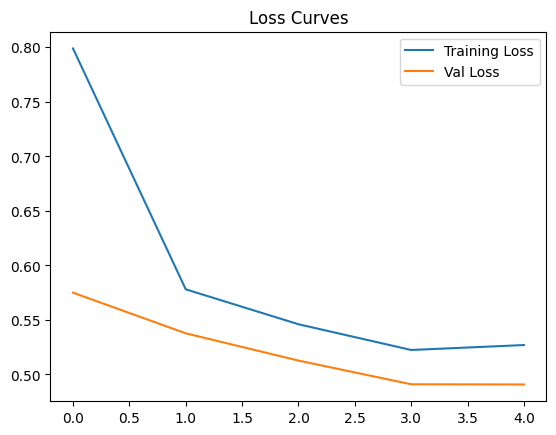

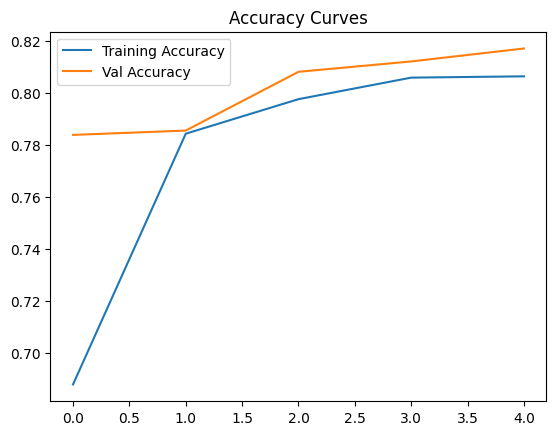

In [29]:
plot_model_history(history_model_conv1d)

In [30]:
# evaluate the model on whole validation set
val_results_model_conv1d = model_conv1d.evaluate(val_dataset_20k)
val_results_model_conv1d

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8185 - loss: 0.4871


[0.49357375502586365, 0.8164636492729187]

## Use Token (word level) and Char Embeddings in a model

In [31]:
# create datasets and batch the data
# use prefetch at the end 
import tensorflow as tf

train_char_dataset_20k = (tf.data.Dataset.from_tensor_slices((train_char_20k, 
                                                              train_labels_20k_one_hot)))
val_char_dataset_20k = tf.data.Dataset.from_tensor_slices((val_char_20k, val_labels_20k_one_hot))
test_Char_dataset_20k = tf.data.Dataset.from_tensor_slices((test_char_20k, test_labels_20k_one_hot))

print(len(train_char_dataset_20k), len(val_char_dataset_20k), len(test_Char_dataset_20k))

BATCH_SIZE = 32

train_char_dataset_20k = train_char_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_char_dataset_20k = val_char_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_Char_dataset_20k = test_Char_dataset_20k.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_char_dataset_20k)

180040 30212 30135
<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [32]:
# use mixed precision policy
# tf.float16 will be used for computations and tf.float32 for saving of variables
# this will speed up the process of training 

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# build a model for token inputs
TOKEN_EMBEDDING_SIZE = 128

token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input_layer")
x = sen_vectorizer_20k(token_inputs)
x = tf.keras.layers.Embedding(input_dim=sen_vocabulary_size_20k,
                              output_dim=TOKEN_EMBEDDING_SIZE)(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# build a model for character embedding inputs
CHAR_EMBEDDING_SIZE = 128

char_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="char_input_layer")
x = char_vectorizer_20k(char_inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocabulary_size_20k,
                              output_dim=CHAR_EMBEDDING_SIZE)(x)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
char_outputs
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

# concatenate token_outputs and char_outputs
token_char_concat = tf.keras.layers.Concatenate(name="token_char_concat_layer")([token_model.output,
                                                                                 char_model.output])
x = tf.keras.layers.Dropout(0.5)(token_char_concat)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
final_outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

final_token_char_model = tf.keras.Model(inputs=[token_inputs, char_inputs],
                                        outputs=final_outputs)




final_token_char_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                               optimizer=tf.keras.optimizers.Adam(),
                               metrics=["accuracy"])

final_token_char_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input_layer   │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 62)        │          0 │ token_input_laye… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 62, 128)   │  8,299,648 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input_layer    │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 58, 64)    │     41,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 239)       │          0 │ char_input_layer… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 239, 128)  │      3,584 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     74,496 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_concat_… │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ token_char_conca… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,460,613 (32.27 MB)

 Trainable params: 8,460,613 (32.27 MB)

 Non-trainable params: 0 (0.00 B)

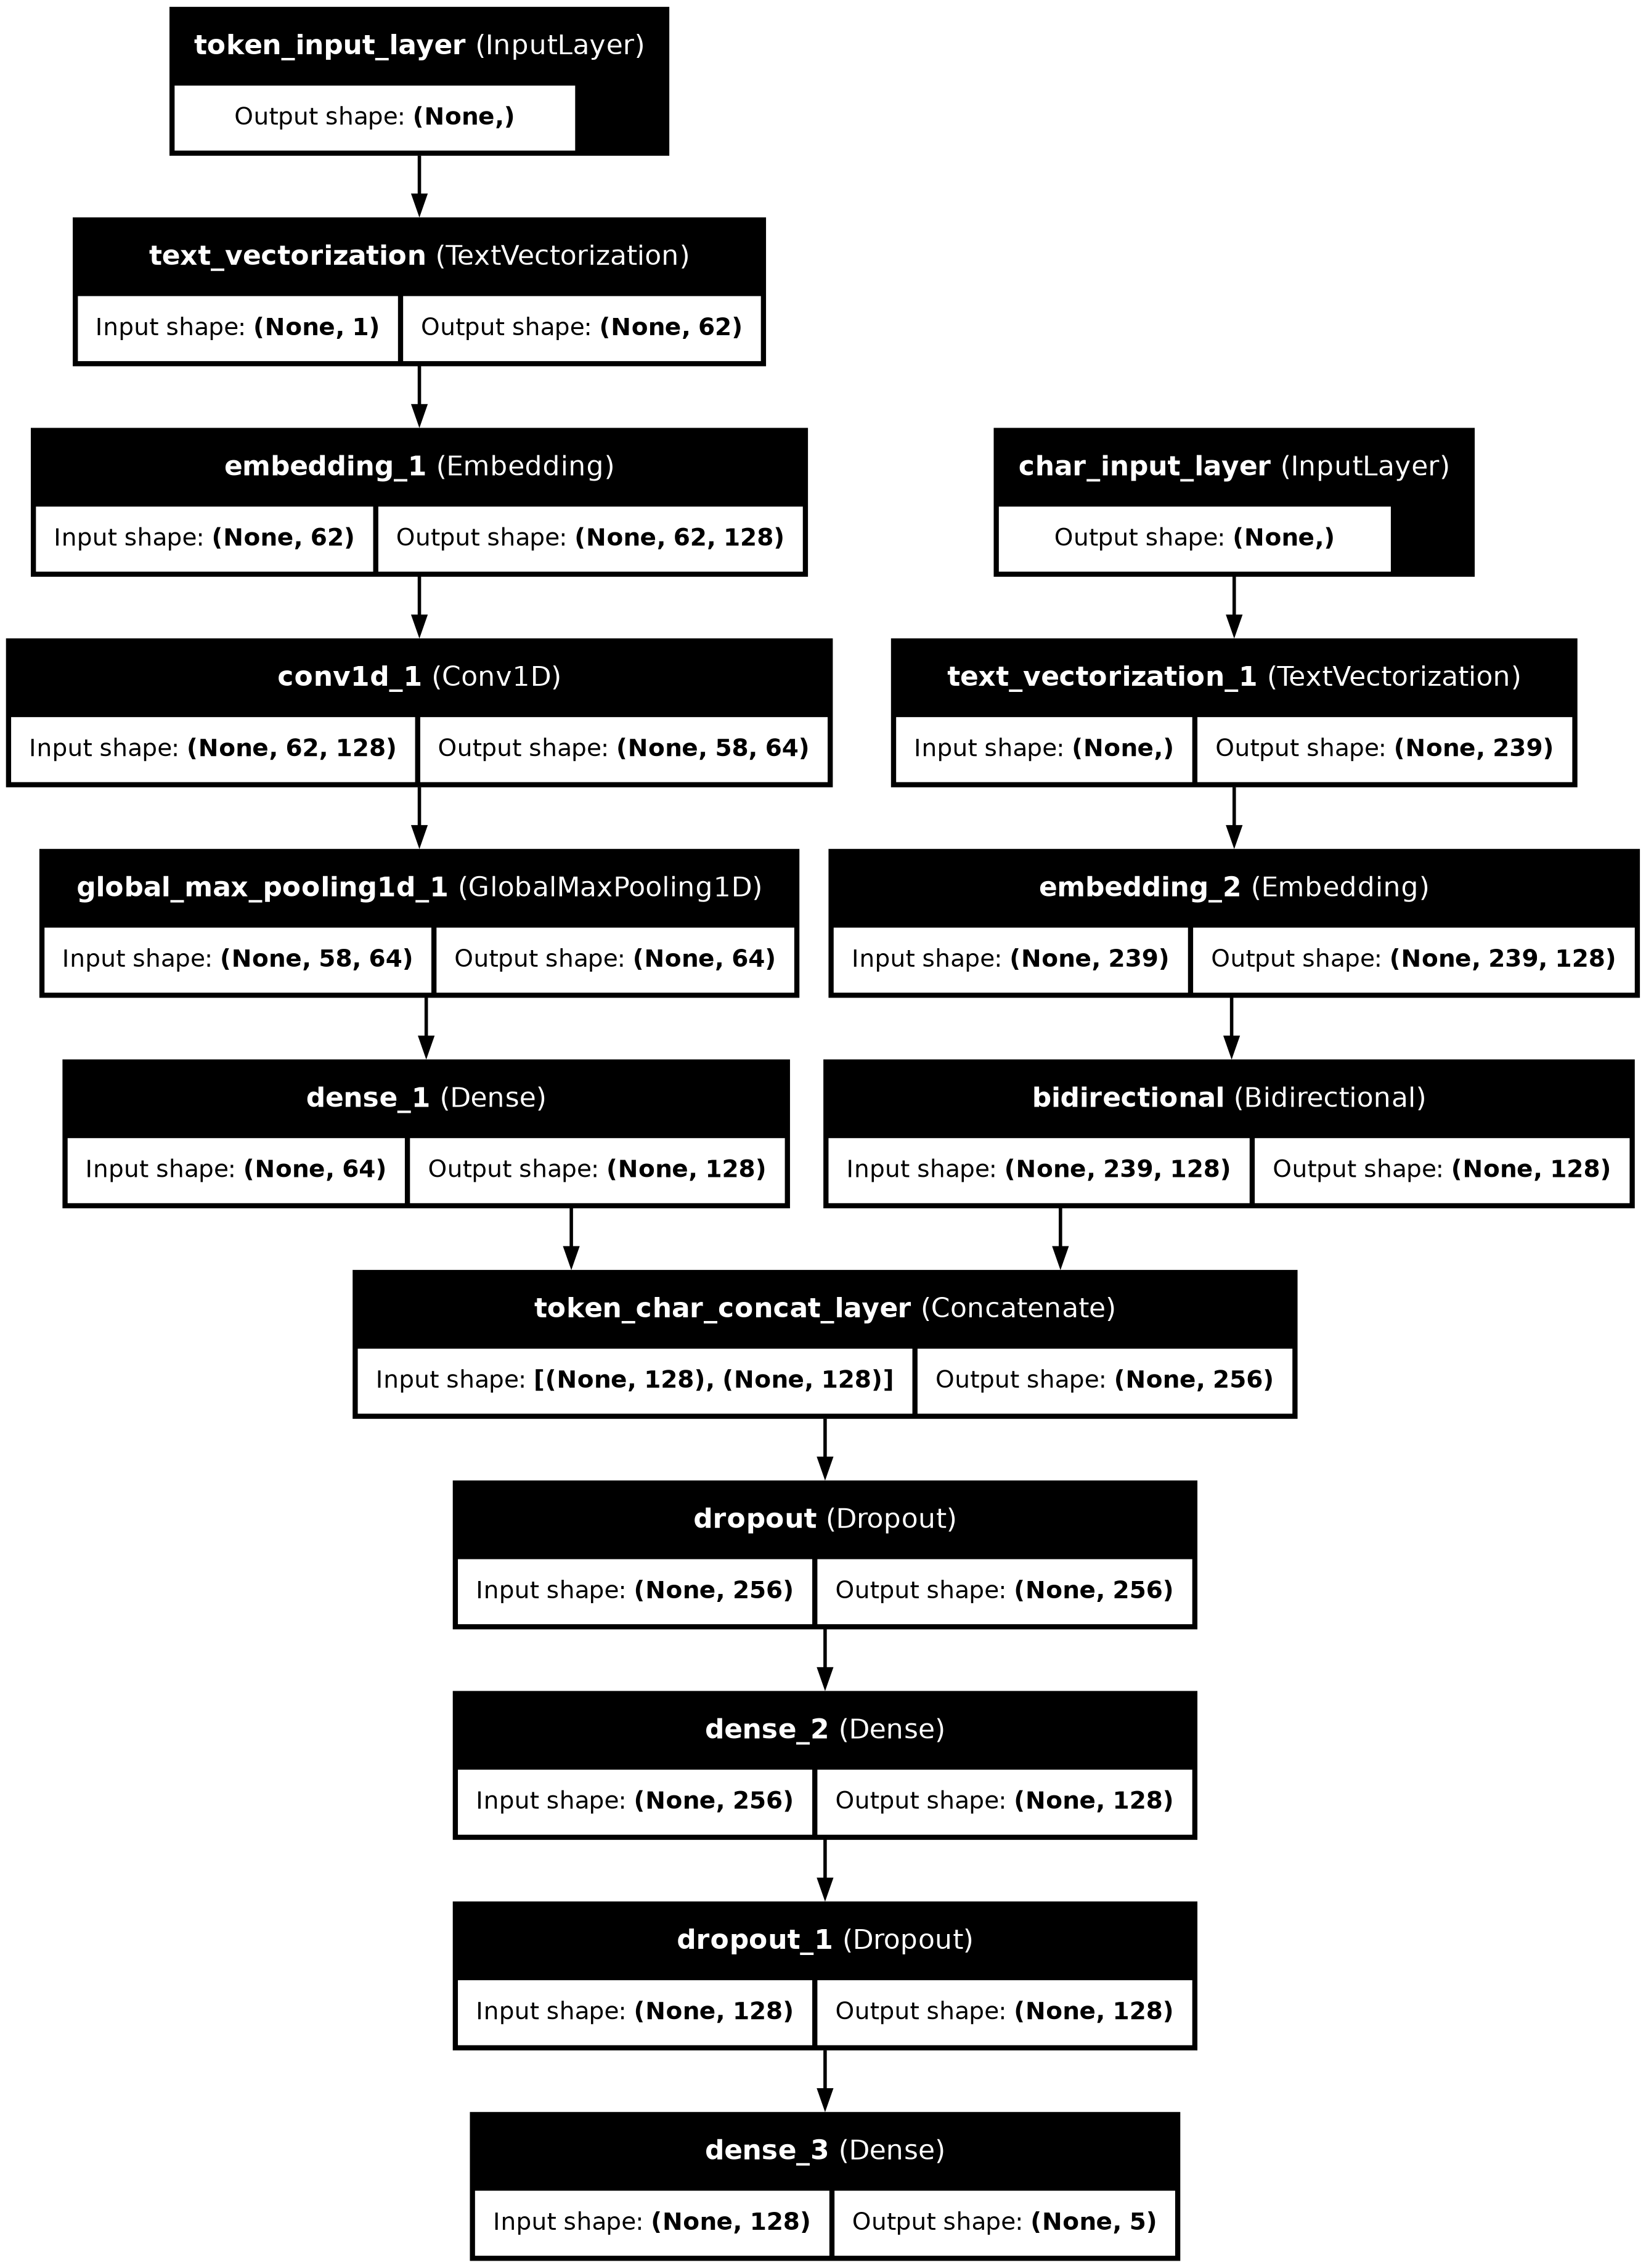

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(final_token_char_model, show_shapes=True, show_layer_names=True)

In [34]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences_20k, train_char_20k))
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences_20k, val_char_20k))
test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences_20k, test_char_20k))

train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_20k_one_hot)
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_20k_one_hot)
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_20k_one_hot)

train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
history_token_char_model = final_token_char_model.fit(train_token_char_dataset,
                                                      epochs=5,
                                                      steps_per_epoch=int(0.1*(len(train_token_char_dataset))),
                                                      validation_data=val_token_char_dataset,
                                                      validation_steps=int(0.1*(len(val_token_char_dataset))),
                                                      verbose=1)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.5014 - loss: 1.1762 - val_accuracy: 0.7773 - val_loss: 0.6018
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7590 - loss: 0.6732 - val_accuracy: 0.7882 - val_loss: 0.5589
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7678 - loss: 0.6182 - val_accuracy: 0.7909 - val_loss: 0.5345
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7855 - loss: 0.5930 - val_accuracy: 0.8092 - val_loss: 0.5098
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7924 - loss: 0.5825 - val_accuracy: 0.8062 - val_loss: 0.5080


In [36]:
# evaluate the model on whole validation set
val_results_final_token_char_model = final_token_char_model.evaluate(val_token_char_dataset)
val_results_final_token_char_model

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8021 - loss: 0.5176


[0.521426260471344, 0.8045809864997864]

## Use Universal Sentence Encoder for Token Embedding

In [37]:
import tensorflow_hub as hub

use_embed_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_embedding_layer = hub.KerasLayer(use_embed_url,
                                     input_shape=[],
                                     trainable=False,
                                     dtype=tf.string,
                                     name="embedding_layer")


In [38]:
def get_embedding_matrix(vocabulary, hub_embedding_layer, num_oov_buckets=0):
    """
    Returns the embedding matrix for a vocabulary. hub_embedding_layer is 
    a pretrained layer from tensorflow_hub.
    
    Args:
        vocabulary (list of str): list containing vocabulary to be embedded
        num_oov_buckets (int): number of out of vocabulary buckets
        hub_embedding_layer (hub.KerasLayer): pretrained embedding layer
        
    Returns:
        embedding_matrix (ndarray): embedding matrix of shape (vocabulay_size, embedding)
                                    for given vocabulary.
    """
    embedding_matrix = []
    for word in vocabulary:
        word_embedding = hub_embedding_layer(tf.constant([word])).numpy()
        embedding_matrix.append(word_embedding)
        
    embedding_matrix = np.vstack(embedding_matrix)
    
    if num_oov_buckets != 0:
        oov_embeddings = np.random.uniform(-0.05, 0.05, (num_oov_buckets, embedding_matrix.shape[1]))
        final_embedding_matrix = np.vstack([oov_embeddings, embedding_matrix])
    else:
        final_embedding_matrix = embedding_matrix
        
    return final_embedding_matrix

In [39]:
sen_vocabulary_20k = sen_vectorizer_20k.get_vocabulary()
print(sen_vocabulary_20k[:10])
print(f"vocabulary size: {sen_vocabulary_size_20k}")

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
vocabulary size: 64841


In [40]:
embedding_matrix = get_embedding_matrix(vocabulary=sen_vocabulary_20k, 
                                        hub_embedding_layer=use_embedding_layer)
embedding_matrix.shape

(64841, 512)

In [41]:
# use pretrained universal sentence encoder for token embedding

# use mixed precision policy
# tf.float16 will be used for computations and tf.float32 for saving of variables
# this will speed up the process of training 

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# # build a model for token inputs
TOKEN_EMBEDDING_SIZE = 512

token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input_layer")
x = sen_vectorizer_20k(token_inputs)
x = tf.keras.layers.Embedding(input_dim=sen_vocabulary_size_20k,
                              output_dim=TOKEN_EMBEDDING_SIZE,
                              weights=[embedding_matrix],
#                               input_length=sequence_length_20k,
                              trainable=False)(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(x)
print(token_outputs)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# build a model for character embedding inputs
CHAR_EMBEDDING_SIZE = 128

char_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="char_input_layer")
x = char_vectorizer_20k(char_inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocabulary_size_20k,
                              output_dim=CHAR_EMBEDDING_SIZE)(x)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
print(char_outputs)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

# concatenate token_outputs and char_outputs
token_char_concat = tf.keras.layers.Concatenate(name="token_char_concat_layer")([token_model.output,
                                                                                 char_model.output])
x = tf.keras.layers.Dropout(0.5)(token_char_concat)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
final_outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

token_use_char_model = tf.keras.Model(inputs=[token_inputs, char_inputs],
                                      outputs=final_outputs)




token_use_char_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

token_use_char_model.summary()

<KerasTensor shape=(None, 128), dtype=float16, sparse=False, name=keras_tensor_23>
<KerasTensor shape=(None, 128), dtype=float16, sparse=False, name=keras_tensor_26>


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input_layer   │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 62)        │          0 │ token_input_laye… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 62, 512)   │ 33,198,592 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input_layer    │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 58, 64)    │    163,904 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 239)       │          0 │ char_input_layer… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 239, 128)  │      3,584 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,320 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     74,496 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_concat_… │ (None, 256)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ token_char_conca… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,482,437 (127.73 MB)

 Trainable params: 283,845 (1.08 MB)

 Non-trainable params: 33,198,592 (126.64 MB)

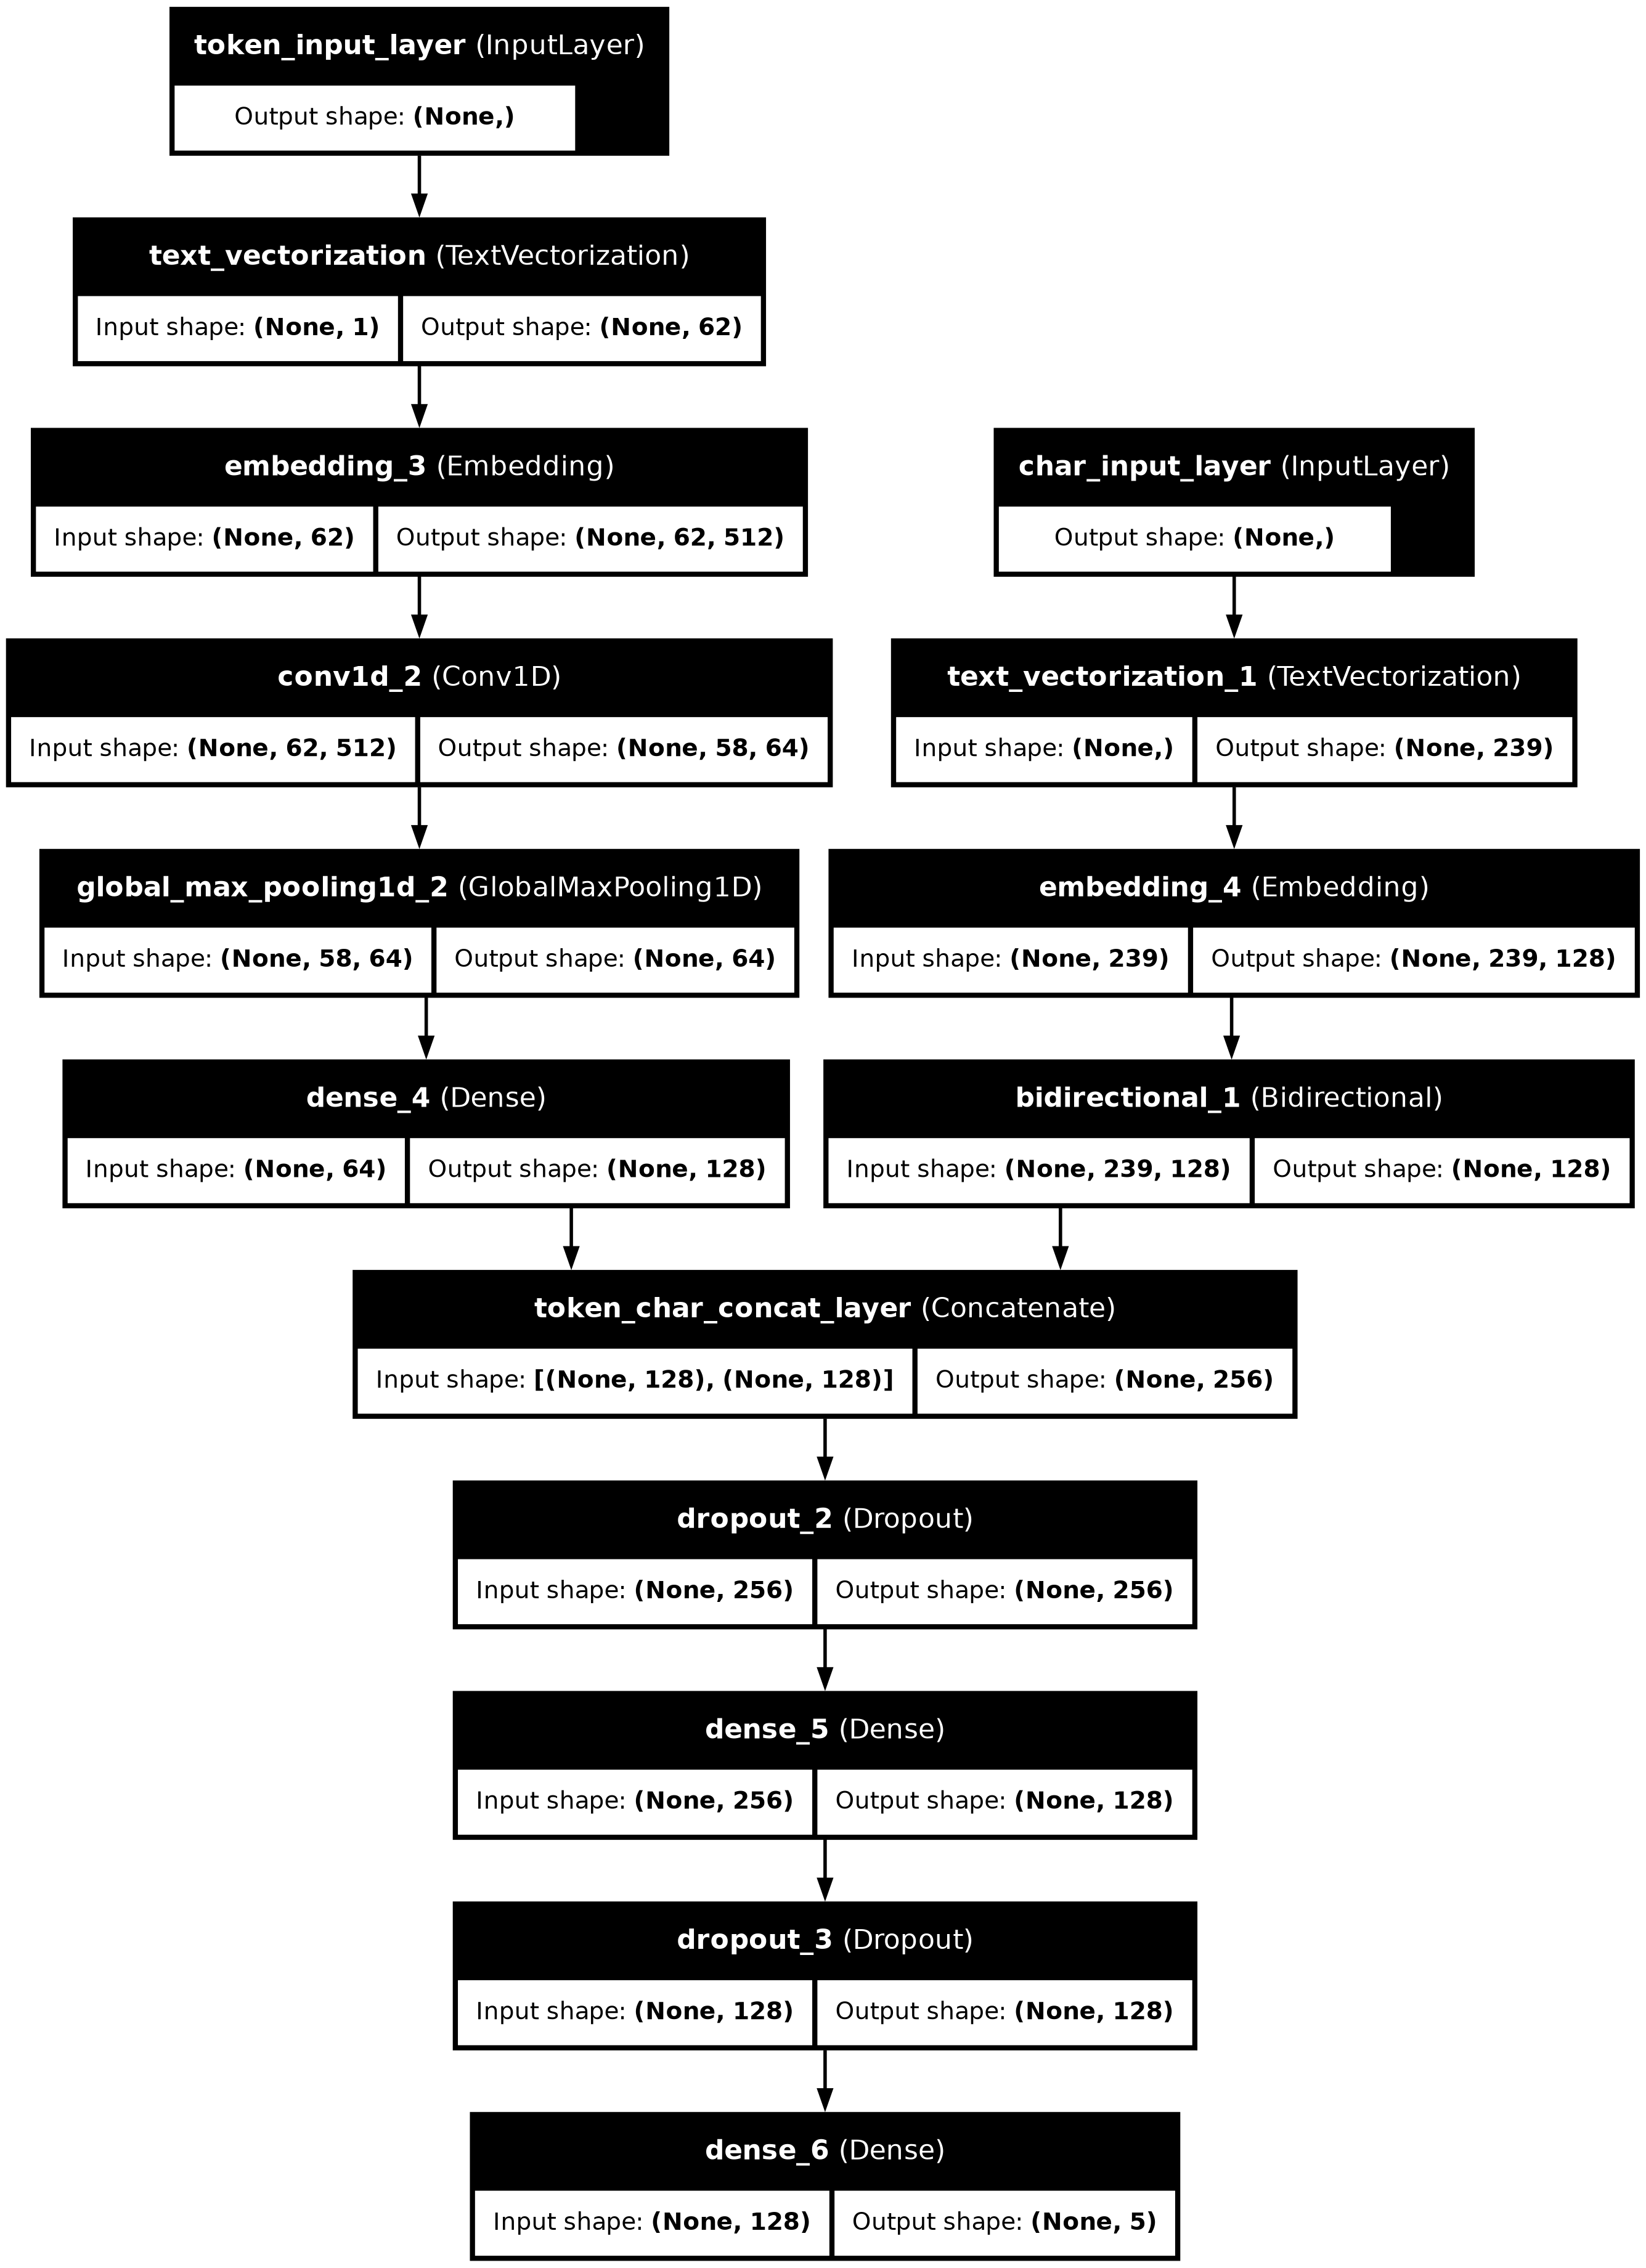

In [42]:
from tensorflow.keras.utils import plot_model

plot_model(token_use_char_model, show_shapes=True, show_layer_names=True)

In [43]:
history_token_use_char_model = token_use_char_model.fit(train_token_char_dataset,
                                                        epochs=5,
                                                        steps_per_epoch=int(0.1*(len(train_token_char_dataset))),
                                                        validation_data=val_token_char_dataset,
                                                        validation_steps=int(0.1*(len(val_token_char_dataset))),
                                                        verbose=1)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5096 - loss: 1.1797 - val_accuracy: 0.7390 - val_loss: 0.6699
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7216 - loss: 0.7277 - val_accuracy: 0.7613 - val_loss: 0.6118
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7447 - loss: 0.6924 - val_accuracy: 0.7753 - val_loss: 0.5918
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7577 - loss: 0.6494 - val_accuracy: 0.8005 - val_loss: 0.5644
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7680 - loss: 0.6385 - val_accuracy: 0.7653 - val_loss: 0.6226


## Use Positional Embeddings
*  (Line numbers and Total lines as input to Model)

In [44]:
# check training df
train_df_20k.head()

,target,sentence,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,A total of @ patients with primary knee OA wer...,1,12
2,METHODS,Outcome measures included pain reduction and i...,2,12
3,METHODS,Pain was assessed using the visual analog pain...,3,12
4,METHODS,Secondary outcome measures included the Wester...,4,12


In [45]:
# check line numbers in training df
train_df_20k["line_number"].value_counts(ascending=False)

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [46]:
max_depth_line_hot = int(train_df_20k["line_number"].quantile(0.99))
max_depth_line_hot

17

<Axes: >

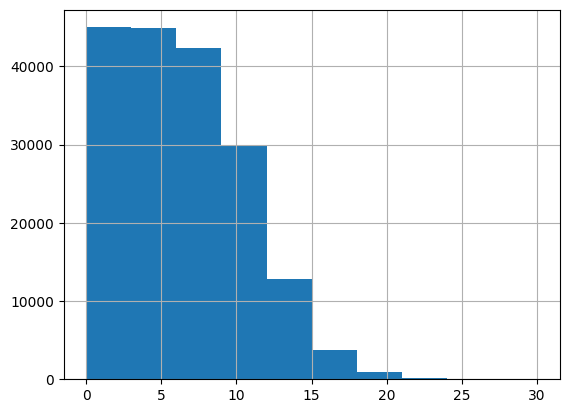

In [47]:
# check the distribution of line numbers
train_df_20k["line_number"].hist()

In [48]:
# convert line_numbers to one_hot encoding
# also set max. line number before encoding to limit the feature dimension
train_line_numbers_20k_one_hot = tf.one_hot(indices=train_df_20k["line_number"].to_numpy(),
                                            depth=max_depth_line_hot)
val_line_numbers_20k_one_hot = tf.one_hot(indices=val_df_20k["line_number"].to_numpy(),
                                            depth=max_depth_line_hot)
test_line_numbers_20k_one_hot = tf.one_hot(indices=test_df_20k["line_number"].to_numpy(),
                                            depth=max_depth_line_hot)

<Axes: >

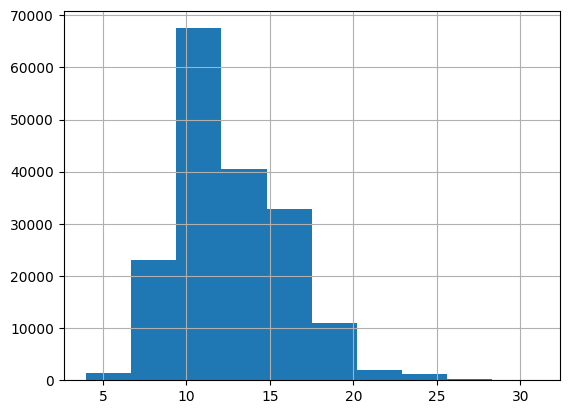

In [49]:
train_df_20k["total_lines"].hist()

In [50]:
max_depth_total_lines_hot = int(train_df_20k["total_lines"].quantile(0.98))
max_depth_total_lines_hot

21

In [51]:
# convert total_lines to one_hot encoding
train_total_lines_20k_one_hot = tf.one_hot(indices=train_df_20k["total_lines"].to_numpy(),
                                           depth=max_depth_total_lines_hot)
val_total_lines_20k_one_hot = tf.one_hot(indices=val_df_20k["total_lines"].to_numpy(),
                                         depth=max_depth_total_lines_hot)
test_total_lines_20k_one_hot = tf.one_hot(indices=test_df_20k["total_lines"].to_numpy(),
                                          depth=max_depth_total_lines_hot)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_input_layer   │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 62)        │          0 │ token_input_laye… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_input_layer    │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 62, 512)   │ 33,198,592 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 239)       │          0 │ char_input_layer… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ embedding_7[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 239, 128)  │      3,584 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     65,664 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     74,496 │ embedding_8[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_concat_… │ (None, 256)       │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ token_char_conca… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │        576 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │        704 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_pos_con… │ (None, 192)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0],   │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 5)         │        965 │ token_char_pos_c… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 33,377,477 (127.32 MB)

 Trainable params: 178,885 (698.77 KB)

 Non-trainable params: 33,198,592 (126.64 MB)

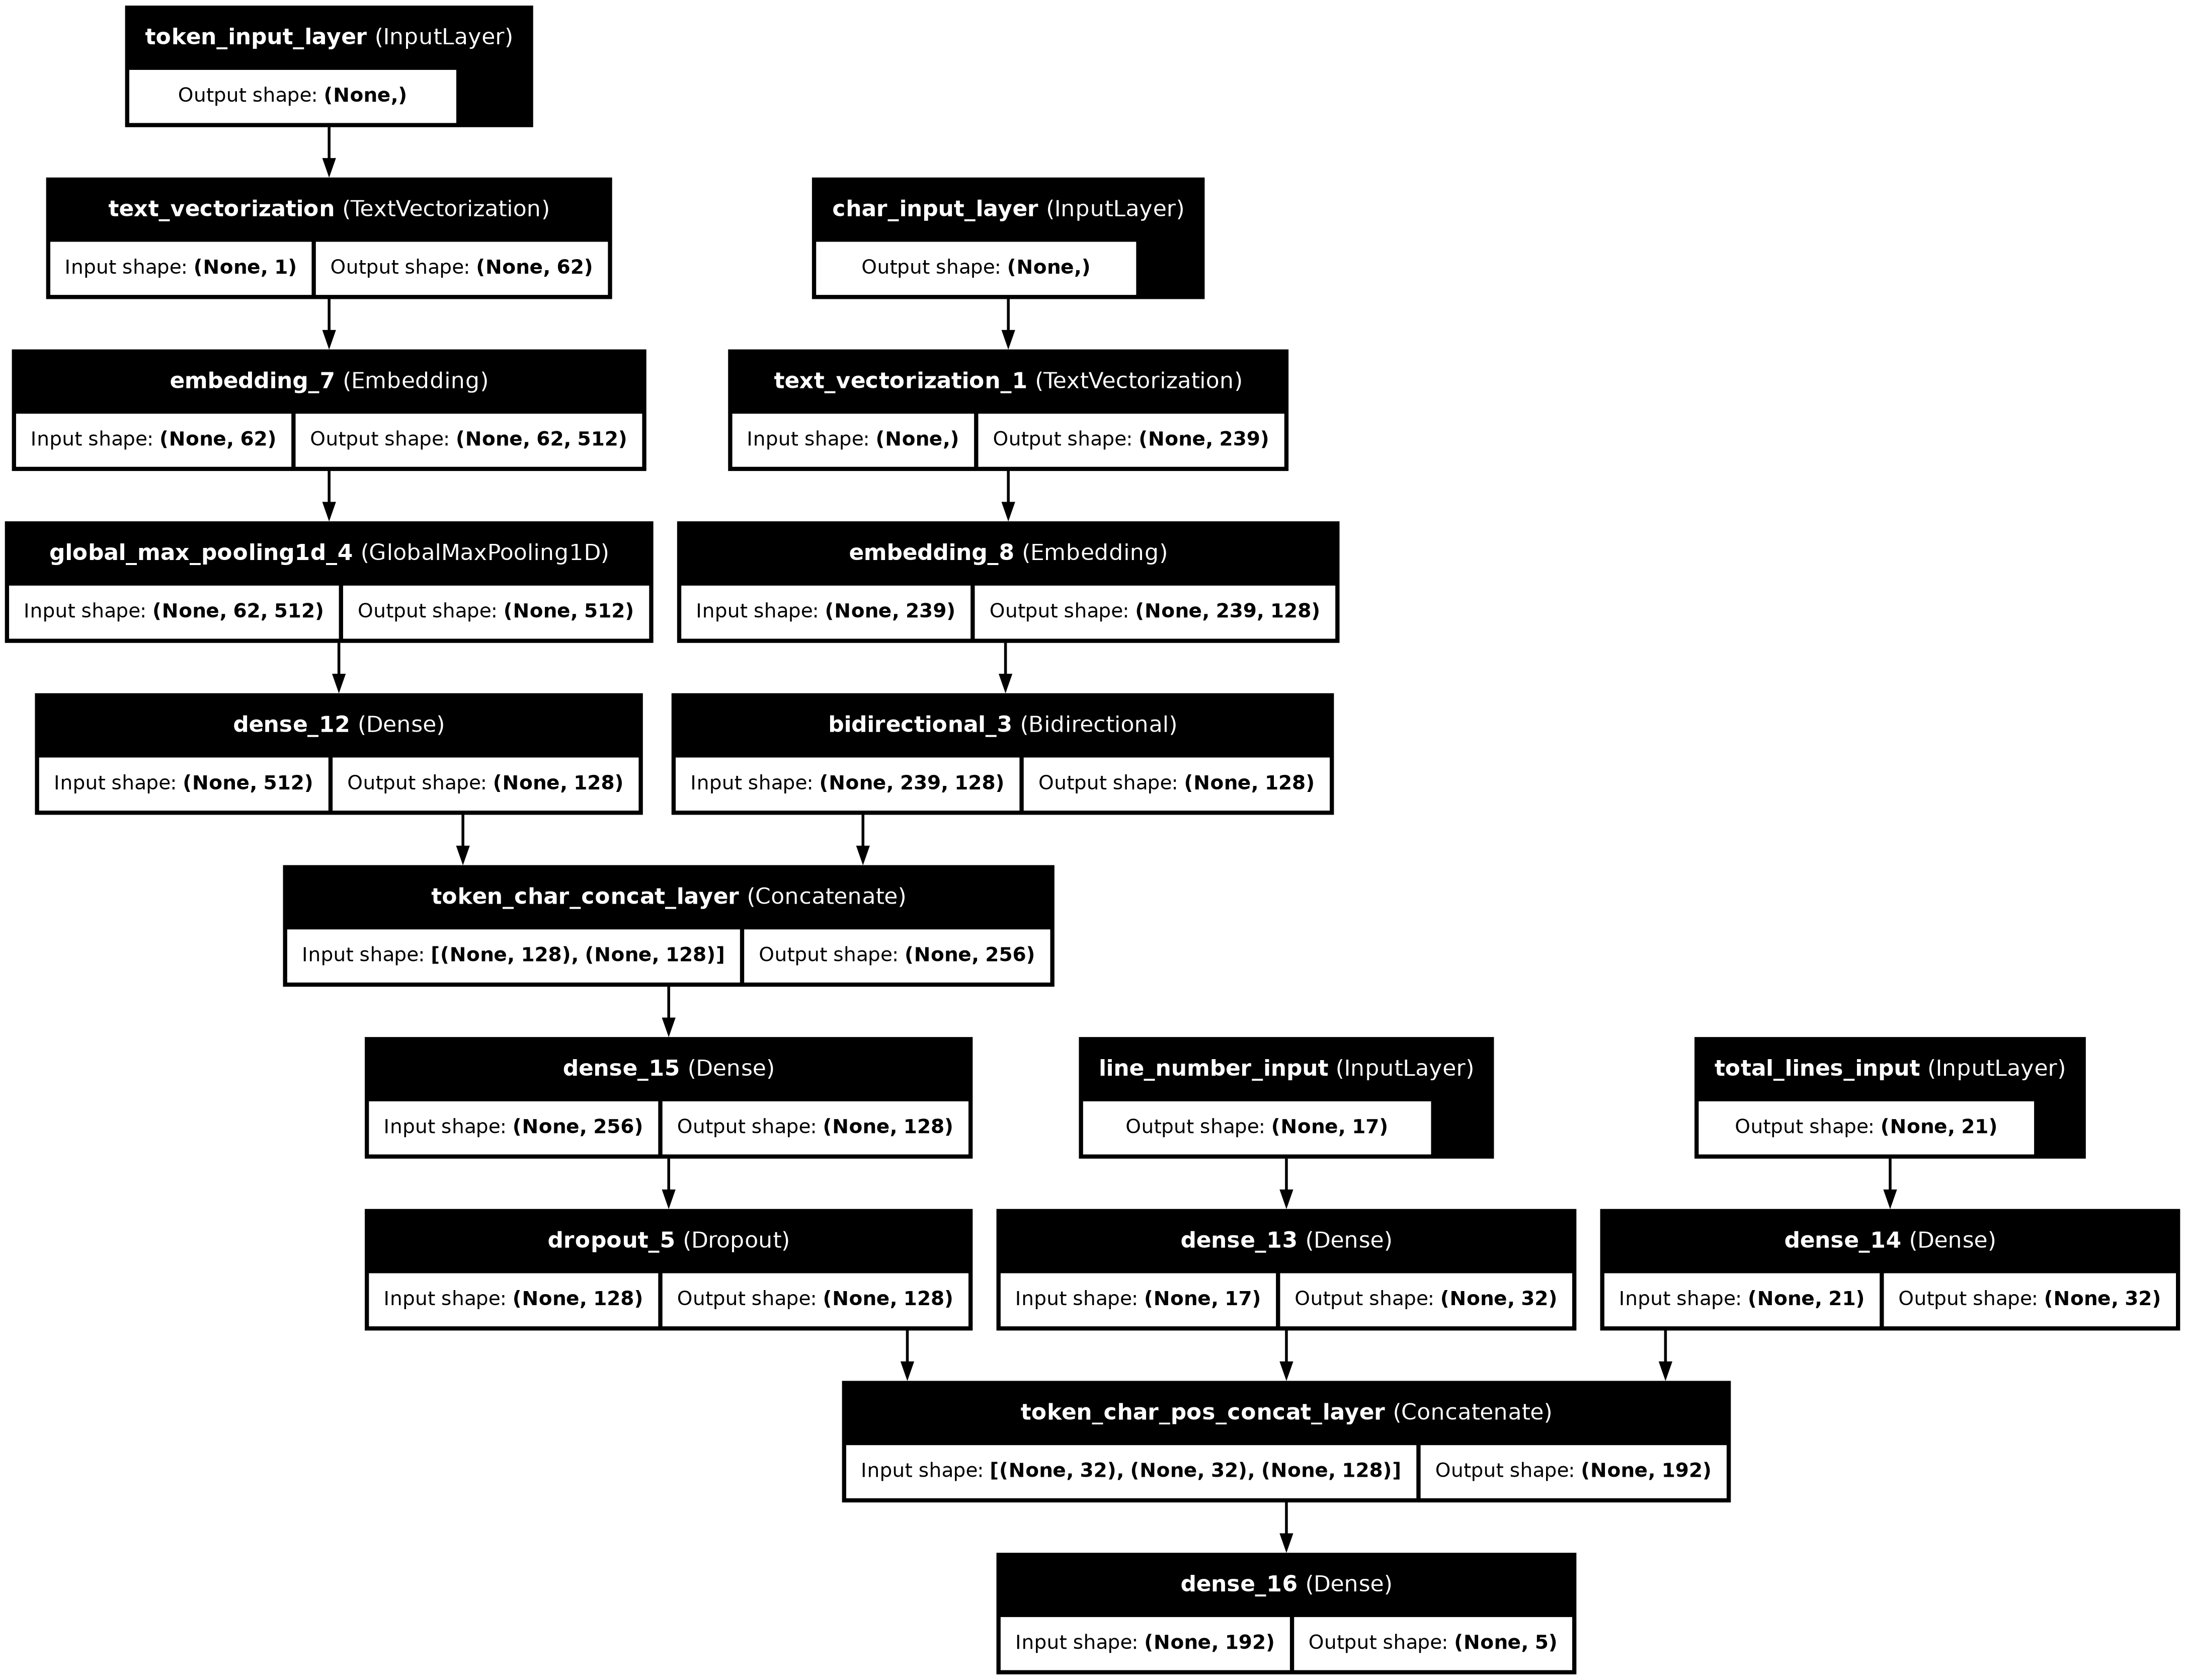

In [58]:
# use pretrained universal sentence encoder for token embedding

# use mixed precision policy
# tf.float16 will be used for computations and tf.float32 for saving of variables
# this will speed up the process of training 

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# # build a model for token inputs
TOKEN_EMBEDDING_SIZE = 512

token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input_layer")
x = sen_vectorizer_20k(token_inputs)
x = tf.keras.layers.Embedding(input_dim=sen_vocabulary_size_20k,
                              output_dim=TOKEN_EMBEDDING_SIZE,
                              weights=[embedding_matrix],
#                               input_length=sequence_length_20k,
                              trainable=False)(x)
# x = tf.keras.layers.Conv1D(filters=64, kernel_size=5)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# build a model for character embedding inputs
CHAR_EMBEDDING_SIZE = 128

char_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="char_input_layer")
x = char_vectorizer_20k(char_inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocabulary_size_20k,
                              output_dim=CHAR_EMBEDDING_SIZE)(x)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_outputs)

# concatenate token_outputs and char_outputs
token_char_concat = tf.keras.layers.Concatenate(name="token_char_concat_layer")([token_model.output,
                                                                                 char_model.output])

# create a model that takes line_number as input
line_number_inputs = tf.keras.layers.Input(shape=(max_depth_line_hot,),
                                           dtype=tf.int32, 
                                           name="line_number_input")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs, 
                                   name="line_number_model")
# create a model that takes total_lines as input
total_lines_inputs = tf.keras.layers.Input(shape=(max_depth_total_lines_hot,), 
                                           dtype=tf.int32, 
                                           name="total_lines_input")
total_lines_outputs = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs, 
                                   name="total_lines_model")

# concatenate all the model outputs and to get final output
# x = tf.keras.layers.Dropout(0.5)(token_char_concat)
x = tf.keras.layers.Dense(128, activation="relu")(token_char_concat)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Concatenate(name="token_char_pos_concat_layer")([line_number_model.output,
                                                                     total_lines_model.output,
                                                                     x])

# final output layer
final_outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

token_use_char_pos_model = tf.keras.Model(inputs=[line_number_model.input,
                                                  total_lines_model.input,
                                                  token_model.input,
                                                  char_model.input],
                                          outputs=final_outputs)




token_use_char_pos_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=["accuracy"])

token_use_char_pos_model.summary()

from tensorflow.keras.utils import plot_model

plot_model(token_use_char_pos_model, show_shapes=True, show_layer_names=True)

In [53]:
# get the data ready for final model
train_dataset_incl_pos_20k = tf.data.Dataset.from_tensor_slices((train_line_numbers_20k_one_hot,
                                                                 train_total_lines_20k_one_hot,
                                                                 train_sentences_20k,
                                                                 train_char_20k))
train_labels_20k_one_hot_dataset = tf.data.Dataset.from_tensor_slices(train_labels_20k_one_hot)
train_dataset_incl_pos_20k = tf.data.Dataset.zip((train_dataset_incl_pos_20k,
                                                  train_labels_20k_one_hot_dataset))
train_dataset_incl_pos_20k = train_dataset_incl_pos_20k.batch(
    32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


val_dataset_incl_pos_20k = tf.data.Dataset.from_tensor_slices((val_line_numbers_20k_one_hot,
                                                               val_total_lines_20k_one_hot,
                                                               val_sentences_20k,
                                                               val_char_20k))
val_labels_20k_one_hot_dataset = tf.data.Dataset.from_tensor_slices(val_labels_20k_one_hot)
val_dataset_incl_pos_20k = tf.data.Dataset.zip((val_dataset_incl_pos_20k,
                                                val_labels_20k_one_hot_dataset))
val_dataset_incl_pos_20k = val_dataset_incl_pos_20k.batch(
    32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


test_dataset_incl_pos_20k = tf.data.Dataset.from_tensor_slices((test_line_numbers_20k_one_hot,
                                                                test_total_lines_20k_one_hot,
                                                                test_sentences_20k,
                                                                test_char_20k,))
test_labels_20k_one_hot_dataset = tf.data.Dataset.from_tensor_slices(test_labels_20k_one_hot)
test_dataset_incl_pos_20k = tf.data.Dataset.zip((test_dataset_incl_pos_20k,
                                                 test_labels_20k_one_hot_dataset))
test_dataset_incl_pos_20k = test_dataset_incl_pos_20k.batch(
    32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

train_dataset_incl_pos_20k, val_dataset_incl_pos_20k, test_dataset_incl_pos_20k

(<_PrefetchDataset element_spec=((TensorSpec(shape=(32, 17), dtype=tf.float32, name=None), TensorSpec(shape=(32, 21), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None)), TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(32, 17), dtype=tf.float32, name=None), TensorSpec(shape=(32, 21), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None)), TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(32, 17), dtype=tf.float32, name=None), TensorSpec(shape=(32, 21), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None)), TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>)

In [54]:
len(train_dataset_incl_pos_20k), len(val_dataset_incl_pos_20k), len(test_dataset_incl_pos_20k)

(5626, 944, 941)

In [55]:
history_token_use_char_pos_model = token_use_char_pos_model.fit(train_dataset_incl_pos_20k,
                                                                epochs=5,
                                                                steps_per_epoch=int(0.1*(len(train_dataset_incl_pos_20k))),
                                                                validation_data=val_dataset_incl_pos_20k,
                                                                validation_steps=int(0.1*(len(val_dataset_incl_pos_20k))),
                                                                verbose=1)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.4666 - loss: 1.2887 - val_accuracy: 0.6862 - val_loss: 0.7961
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7001 - loss: 0.7563 - val_accuracy: 0.7676 - val_loss: 0.5909
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7444 - loss: 0.6428 - val_accuracy: 0.7763 - val_loss: 0.5527
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7741 - loss: 0.5765 - val_accuracy: 0.8045 - val_loss: 0.5257
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7909 - loss: 0.5483 - val_accuracy: 0.8015 - val_loss: 0.4958


In [56]:
token_use_char_pos_model.evaluate(val_dataset_incl_pos_20k)

944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8088 - loss: 0.5056


[0.5083242058753967, 0.8080309629440308]

In [59]:
# train the model for complete 20k training data
# first rebuild and compile the model by running the previous cell where it was defined

history_token_use_char_pos_model = token_use_char_pos_model.fit(train_dataset_incl_pos_20k,
                                                                epochs=3,
#                                                                 steps_per_epoch=int(len(train_dataset_incl_pos_20k)),
                                                                validation_data=val_dataset_incl_pos_20k,
                                                                validation_steps=int(0.1*(len(val_dataset_incl_pos_20k))),
                                                                verbose=1)

Epoch 1/3
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 116s 20ms/step - accuracy: 0.6852 - loss: 0.7785 - val_accuracy: 0.7949 - val_loss: 0.5046
Epoch 2/3
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.8217 - loss: 0.4690 - val_accuracy: 0.8334 - val_loss: 0.4078
Epoch 3/3
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - accuracy: 0.8437 - loss: 0.4189 - val_accuracy: 0.8278 - val_loss: 0.4203


In [60]:
token_use_char_pos_model.evaluate(val_dataset_incl_pos_20k)

944/944 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8317 - loss: 0.4281


[0.4298100769519806, 0.8320974707603455]